# 3.8 연습 문제

## 문제 2

MNIST 이미지를 (왼쪽, 오른쪽, 위쪽, 아래쪽) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수를 만들어보자.  
그런 다음 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본(방향마다 한 개씩)을 만들어 훈련 세트에 추가한다.  
마지막으로 이 확장된 데이터셋에서 문제 1 에서 찾은 최선의 모델을 훈련시키고 테스트 세트에서 정확도를 평가해봐서 모델 성능이 더 높아졌는 지 확인해보자.  
이렇게 인위적으로 훈련 세트를 늘리는 기법을 **데이터 증식** 또는 **훈련 세트 확장(training set expansion)**이라고 한다.


**힌트**

- 이미지 픽셀 이동은 `scipy.ndimage.interpolation` 모듈의 `shift()` 함수를 사용할 수 있다.
  - ex) `shift(image, [2, 1], cval=0)` : 아래로 2픽셀, 오른쪽으로 1픽셀 이동

<br>

## 라이브러리 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

<br>

## 데이터셋 불러오기

In [2]:
# MNIST 데이터셋 불러오기
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

<br>

## 데이터 분리

In [3]:
# 데이터셋 분리
X, y = mnist['data'], mnist['target']

# 레이블 데이터 타입 변환(문자열 -> 숫자)
y = y.astype(np.uint8)

# 테스트 세트 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<br>

## 모델 불러오기

In [4]:
import joblib

#models_path = "./drive/MyDrive/Colab Notebooks/models/"
models_path = "../../models/"

grid_search = joblib.load(models_path + 'mnist_knn_clf_grid_search.pkl')
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

<br>

## 데이터 증식

### 이미지 픽셀 이동 함수 정의

In [5]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

<br>

### 이미지 픽셀 이동 예시 확인

In [6]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

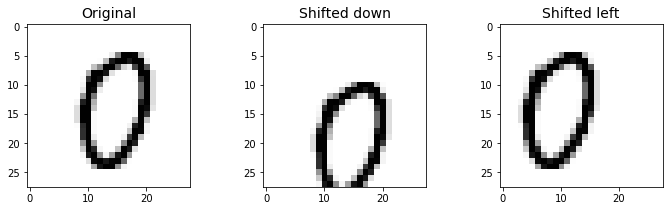

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,3))

plt.subplot(131)
plt.title('Original', fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation='nearest', cmap='Greys')

plt.subplot(132)
plt.title('Shifted down', fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation='nearest', cmap='Greys')

plt.subplot(133)
plt.title('Shifted left', fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation='nearest', cmap='Greys')

plt.show()

<br>

### 이미지 픽셀 이동 함수를 활용한 데이터 증식

In [8]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

<br>

### 훈련 데이터 순서 섞기

In [9]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

<br>

## 모델 학습, 예측 및 평가

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [11]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [12]:
from sklearn.metrics import accuracy_score

y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763